#**SCC5830 - Processamento de imagens**

## Preenchimento de profundidade em imagens RGB-D coletadas por Kinect

###### **Autor:** Augusto Ribeiro Castro 
###### **Número USP:** 9771421

#### Carregamento dos dados a partir do Google Drive

Este notebook foi desenvolvido no Google Colab a fim de aproveitar a GPU fornecida gratuitamente pela ferramenta. Sendo assim, as próximas células dizem respeito exclusivamente a importação da pasta do Google Drive contendo o conjunto de dados deste trabalho, disponível para download [aqui]( http://www.mae.cuhk.edu.hk/~cwang/Projects/RGBDCompletionCNNDataset.zip). 

In [31]:
import os
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mover o diretório para aquele contendo a pasta com o conjunto de dados:

In [32]:
cd /content/drive/MyDrive/Processamento\ de\ imagens

/content/drive/MyDrive/Processamento de imagens


In [33]:
PATH = os.getcwd()
print(PATH)

/content/drive/MyDrive/Processamento de imagens


Guardar o caminho para o conjunto de dados, armazenado na pasta "Depth completion" e contabilizar o número total de imagens, considerando as imagens coloridas, as imagens de profundidade não processadas e as imagens de profundidade de saída (este número deve ser igual a 3906 para o conjunto de dados proposto). Sendo assim, o total de tuplas de treinamento é igual a um terço do valor mostrado abaixo (1302).

In [34]:
DATASET_PATH = os.path.join(PATH, 'Depth completion')
num_images = len(os.listdir(DATASET_PATH))
print('Número total de imagens: ', num_images)

Número total de imagens:  3906


# Definição do problema

Por ter sido escolhido um problema de processamento de imagens cuja solução (gerar imagens RGB-D completas) geralmente envolve o uso de redes neurais convolucionais, a biblioteca PyTorch foi escolhida para elaboração dos modelos a serem desenvolvidas no trabalho. A escolha foi baseada no simples desejo de ter um primeiro contato com PyTorch ao invés de utilizar o Tensorflow. As demais bibliotecas utilizadas e importadas abaixo estão dentro daquelas comumente utilizadas no curso.

In [35]:
import torch
import imageio
import numpy as np

#### Dataset e imagens envolvidas

Definição da classe responsável por carregar as tuplas do conjunto de dados:

In [36]:
class DepthCompletionDataset(torch.utils.data.Dataset):
  def __init__(self, img_dir, img_token, depth_token, raw_token, file_extension):
    self.img_dir = img_dir
    self.file_extension = file_extension
    self.input_token = img_token

    self.rawDepth_files = []
    self.depth_files = []
    self.image_files = []
    for img in os.listdir(self.img_dir):
      if ('-'+str(img_token)+self.file_extension) in img:
        self.image_files.append(img)
      elif ('-'+str(depth_token)+self.file_extension) in img:
        self.depth_files.append(img)
      elif ('-'+str(raw_token)+self.file_extension) in img:
        self.rawDepth_files.append(img)

    self.image_files = np.sort(self.image_files)
    self.depth_files = np.sort(self.depth_files)
    self.rawDepth_files = np.sort(self.rawDepth_files)

  def __len__(self):
    img_number = 0
    for img in os.listdir(self.img_dir):
      if ('-'+str(self.input_token)+self.file_extension) in img:
        img_number += 1
    return img_number

  def __getitem__(self, idx):
    idx_len = len(str(idx))
    if idx_len > 5:
      raise Exception('Index out of range')

    image_filename = os.path.join(self.img_dir, self.image_files[idx])
    depth_filename = os.path.join(self.img_dir, self.depth_files[idx])
    rawDepth_filename = os.path.join(self.img_dir, self.rawDepth_files[idx])

    image = torch.from_numpy(np.expand_dims(np.array(imageio.imread(image_filename)), axis=0).astype(np.float32))
    depth = torch.from_numpy(np.expand_dims(np.array(imageio.imread(depth_filename)), axis=0).astype(np.float32))
    rawDepth = torch.from_numpy(np.expand_dims(np.array(imageio.imread(rawDepth_filename)), axis=0).astype(np.float32))

    return image.float(), rawDepth.float(), depth.float()

    

As células abaixo mostram como os dados podem ser carregados e mostrados na forma de imagem. **As imagens de profundidade foram normalizadas para fins de visualização.** Por terem sido adquiridas a partir de um sensor kinect, os valores armazenados estão em milímetros e no intervalo [500, 8000].

In [37]:
## Função auxiliar para normalizar imagens para o intervalo [0, scale_factor].
## Útil para visualização e futuramente pode ser utilizada no método.

def min_max_norm(img, scale_factor=255):
  return scale_factor*(img-np.min(img))/(np.max(img)-np.min(img))

In [38]:
dataset = DepthCompletionDataset(DATASET_PATH, 'color', 'depth', 'rawDepth', '.png')

In [39]:
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Pegar uma tupla e mostrar o tipo dos dados
color, rawDepth, depth = dataset.__getitem__(0)
print(type(color))
print(color.shape)

# Converter as imagens de tensores para numpy
color = color.numpy()
rawDepth = rawDepth.numpy()
depth = depth.numpy()

<class 'torch.Tensor'>
torch.Size([1, 480, 640, 3])


Text(0.5, 1.0, 'Saída: profundidade preenchida verdadeira (normalizada)')

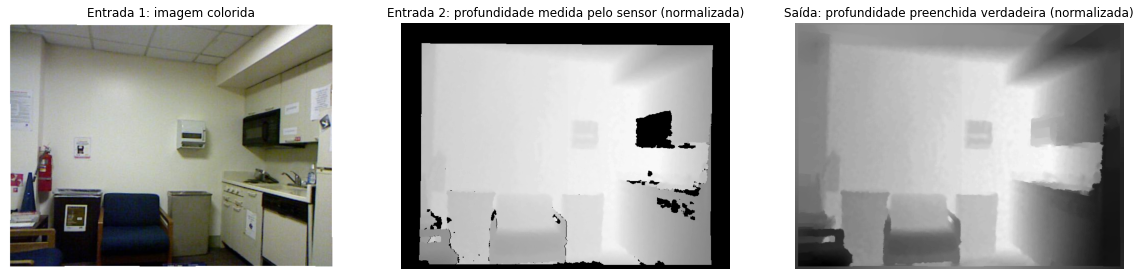

In [40]:
# Formato dos tensores do PyTorch:
# batch_size, height, width, channel
# Converter para apenas height, width, channel para visualizar a imagem colorida
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(color[0].astype(np.uint8))
plt.axis('off')
plt.title('Entrada 1: imagem colorida')

plt.subplot(132)
plt.imshow(min_max_norm(rawDepth[0]).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.title('Entrada 2: profundidade medida pelo sensor (normalizada)')

plt.subplot(133)
plt.imshow(min_max_norm(depth[0]).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.title('Saída: profundidade preenchida verdadeira (normalizada)')

#### Funções auxiliares

Função auxiliar que divide o conjunto de dados em dois conjuntos disjuntos de treino e de validação de forma aleatória para a proporção fornecida, além de agrupar os dados em lotes. Retorna dois DataLoaders, que são estruturas iteráveis e que podem ser utilizadas como entrada de um modelo no PyTorch. 

In [41]:
def train_test_split(dataset, validation_split, batch_size, shuffle_dataset=True, random_seed=42):
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]

  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  sampler=valid_sampler)

  return train_loader, validation_loader

Funções auxiliares implementadas com base no artigo [Alhashim, I., & Wonka, P. (2018). High quality monocular depth estimation via transfer learning.](https://arxiv.org/pdf/1812.11941.pdf) Ambas as técnicas de calcular a recíproca normalizada dos valores de profundidade quanto de definir uma função de custo baseada na soma das diferenças dos gradientes em x e em y das imagens de profundidade preditas e verdadeiras são utilizadas pelo artigo citado numa tarefa de estimativa de profundidade a partir de imagens RGB, que é uma tarefa parecida com aquela abordada neste trabalho. As funções estão implementadas, mas ainda necessitam de depuração.

###### 1) Normalização da profundidade:

In [42]:
def depth_norm(img, max_reference):
  return max_reference/img

###### 2) Função de custo baseada no gradiente das imagens:

In [43]:
def img_gradients(img):
  device = 'cuda' if img.is_cuda else 'cpu'
  batch, channel, h, w = img.shape

  # Filtro Sobel para a direção x:
  kernel_x = torch.from_numpy(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])).to(device).unsqueeze(0).expand(1, channel, -1, -1).float()
  gx = torch.nn.functional.conv2d(img, kernel_x, padding=1)

  # Filtro Sobel para a direção y:
  kernel_y = torch.from_numpy(np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])).to(device).unsqueeze(0).expand(1, channel, -1, -1).float()
  gy = torch.nn.functional.conv2d(img, kernel_y, padding=1)

  return gx, gy

A ideia por trás de definir uma função de custo baseada na diferença dos gradientes é de tentar aprimorar os contornos da imagem predita de modo que eles se aproximem da imagem original.

In [44]:
def gradient_loss(outputs, target):
  gx_outputs, gy_outputs = img_gradients(outputs)
  gx_targets, gy_targets = img_gradients(target)

  return torch.mean(torch.abs(gx_outputs-gx_targets)+torch.abs(gy_outputs-gy_targets))

###### 3) Similaridade estrutural:

A similaridade estrutural (SSIM) é uma métrica de comparação entre imagens que busca estimar o quão parecidas são duas imagens com base na interdenpendência de pixels que estão espacialmente próximos, diferentemente de outras métricas como o erro quadrático médio (MSE). A biblioteca scikit-image possui um ótimo [exemplo](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html) de situação em que imagens diferentes possuem o mesmo MSE, mesmo sendo claramente diferentes. Nessa situação, a SSIM é melhor em discriminá-las.

A SSIM implementada é calculada para duas janelas gaussianas x e y de dimensões 11x11 e com $\sigma = 1,5$ de acordo com a literatura. A partir disso:

[$$SSIM(x, y) = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1)(\sigma_x^2+\sigma_y^2+c_2)}$$](https://en.wikipedia.org/wiki/Structural_similarity)



*   $\mu$: média dos valores na janela
*   $\sigma^2:$ variância dos valores na janela
*   $\sigma_{xy}$: covariância
*   $c_1 = (k_1 L)^2$, $k_1 = 0,01$
*   $c_2 = (k_2 L)^2$, $k_1 = 0,03$
*   $L$: intervalo absoluto de valores dos pixels. Neste caso, L = 7500.

Função que retorna o filtro gaussiano para o tamanho e o desvio padrão escolhido:

In [45]:
def gaussian_kernel(size, sigma):
  axis = np.arange((-size // 2)+1.0, (size // 2) + 1.0)
  x, y = np.meshgrid(axis, axis)
  kernel = np.exp(-(1/2)*(np.square(x)+np.square(y))/np.square(sigma))
  return kernel/kernel.sum()

Função que calcula a SSIM:

In [46]:
def ssim(img1, img2, window_size, L):
  device = 'cuda' if img1.is_cuda else 'cpu'
  kernel = torch.from_numpy(gaussian_kernel(window_size, 1.5)).to(device)
  batch_size, channels, height, width = img1.size()
  kernel = kernel.unsqueeze(0).expand(1, channels, -1, -1).float()

  # print(img1.size())
  # print(kernel.size())
  # print(kernel)

  mu_1 = torch.nn.functional.conv2d(img1, kernel, groups=channels)
  # print(mu_1.size())
  mu_2 = torch.nn.functional.conv2d(img2, kernel, groups=channels)
  mu_squared_1 = torch.pow(mu_1, 2)
  mu_squared_2 = torch.pow(mu_2, 2)

  sigma_squared_1 = torch.nn.functional.conv2d(img1*img1, kernel, groups=channels) - mu_squared_1
  sigma_squared_2 = torch.nn.functional.conv2d(img2*img2, kernel, groups=channels) - mu_squared_2
  covariance = torch.nn.functional.conv2d(img1*img2, kernel, groups=channels) - mu_1*mu_2

  k1 = 0.01
  k2 = 0.03

  c1 = (k1*L)**2
  c2 = (k2*L)**2

  ret = ((2*mu_1*mu_2+c1)*(2*covariance+c2))/((mu_squared_1+mu_squared_2+c1)*(sigma_squared_1+sigma_squared_2+c2))
  return ret

A SSIM definida retorna valores no intervalo [-1, 1], sendo o último quando as imagens são iguais. Como a ideia envolvida no treinamento de uma rede neural artificial é de minimizar uma função de erro, a SSIM pode ser aplicada como função de custo ao definir a disparidade ($disp(img_1, img_2)$) da seguinte forma:

$$disp(img_1, img_2) = \frac{1-ssim(img_1, img_2)}{2}$$

Conforme definida acima, é fácil notar que a disparidade está contida no intervalo [0, 1] e que a minimização da disparidade significa obter imagens mais parecidas, conforme é desejado para uma função de custo.

In [47]:
def structural_disparity_loss(outputs, target):
  similarity = ssim(outputs, target).mean()
  return (1-similarity)/2.0

Exemplo de aplicação entre pares do dataset:

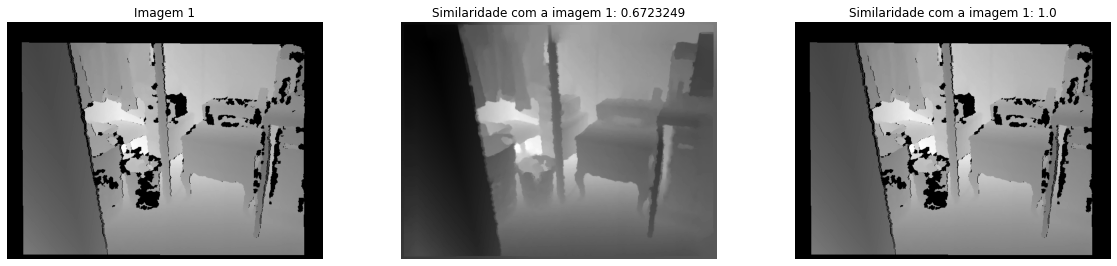

In [63]:
# from skimage.metrics import structural_similarity

train_loader, test_loader = train_test_split(dataset, 0.1, 4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i, data in enumerate(test_loader):
  _, inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

  similarity = ssim(inputs, labels, 11, 7500.0).mean(1).mean(1).mean(1)
  dummy_sim = ssim(inputs, inputs, 11, 7500.0).mean(1).mean(1).mean(1)
  inputs = inputs.cpu()
  labels = labels.cpu()

  plt.figure(figsize=(20,20))
  plt.subplot(131)
  plt.imshow(inputs[0, 0], cmap='gray')
  plt.axis('off')
  plt.title('Imagem 1')
  plt.subplot(132)
  plt.imshow(labels[0, 0], cmap='gray')
  plt.axis('off')
  plt.title('Similaridade com a imagem 1: '+str(similarity.numpy()[0]))
  plt.subplot(133)
  plt.imshow(inputs[0, 0], cmap='gray')
  plt.axis('off')
  plt.title('Similaridade com a imagem 1: '+str(dummy_sim.numpy()[0]))

  # print(structural_similarity(input, label, gaussian_weight=True, win_size=11, sigma=1.5, data_range=7500.0))
  # print(structural_similarity(inputs[1, 0].detach().numpy(), labels[1, 0].detach().numpy(), gaussian_weight=True, win_size=11, sigma=1.5, data_range=7500.0))
  # print(structural_similarity(inputs[2, 0].detach().numpy(), labels[2, 0].detach().numpy(), gaussian_weight=True, win_size=11, sigma=1.5, data_range=7500.0))
  # print(structural_similarity(inputs[3, 0].detach().numpy(), labels[3, 0].detach().numpy(), gaussian_weight=True, win_size=11, sigma=1.5, data_range=7500.0))
  # print((1-similarity)/2)
  break

# Modelo de rede neural utilizado:

Como o problema proposto tem como entradas imagens e como saída uma outra imagem na qual é desejado prever o valor de profundidade em cada pixel, ele se encaixa como um problema de regressão e também como um problema em que auto-codificadores se encaixam perfeitamente. Até o momento o primeiro modelo treinado, presente abaixo, consiste em uma rede em U em que saídas do codificador são concatenadas com saídas do decodificador de mesmo tamanho, como é comum na literatura. 

O modelo recebe como entrada apenas a imagem crua e minimiza o erro quadrático médio em relação à imagem de profundidade completa. Essa abordagem ainda será melhor explorada, adicionando a imagem colorida para obter melhores resultados e criando uma função de custo mais apropriada a partir das funções auxiliares definidas acima.

#### Bloco básico do codificador:

O codificador é composto por blocos como o definido abaixo, em que uma duas camadas convolucionais são aplicadas com a função de ativação retificadora, com o intuito de aumentar o número de canais. Entre elas, é aplicada uma camada de redução baseada na média (conforme geralmente aparece na literatura de estimativa de profundidade) para reduzir pela metade a altura e a largura do tensor de entrada. Como regularização, é utilizada ainda a normalização em lotes.

In [65]:
class EncoderBlock(torch.nn.Module):
  def __init__(self, input_channels, output_channels):
    super(EncoderBlock, self).__init__()
    self.conv_1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
    self.conv_2 = torch.nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1)
    self.batch_norm = torch.nn.BatchNorm2d(output_channels)
    self.pooling_layer = torch.nn.AvgPool2d(2)
    self.relu_1 = torch.nn.ReLU()
    self.relu_2 = torch.nn.ReLU()

  def forward(self, x):
    x = self.relu_1(self.conv_1(self.pooling_layer(x)))
    x = self.relu_2(self.batch_norm(self.conv_2(x)))
    return x

#### Bloco básico do decodificador:

Cada bloco do decodificador busca dobrar a altura e a largura do tensor de entrada e reduzir a profundidade, a fim de dar passos em direção à reconstrução da imagem comprimida na etapa anterior. Este bloco é composto então por 3 camadas convolucionais, sendo duas delas de filtros 1x1 para redução pela metade do número de canais. 

A primeira redução acontece para tornar a dimensão compatível com a entrada recebida da camada codificadora correspondente, que é concatenada à saída do bloco anterior da etapa de convolução. A segunda redução ocorre para reduzir pela metade os canais de saída do bloco. 

Para reverter a camada de redução pela média do bloco codifcador, a operação inversa é implementada por uma interpolação bilinear no PyTorch, já que, diferentemente do Tensorflow, ele não possui uma camada que faz o mesmo processo, mas em forma de camada. 

In [66]:
class DecoderBlock(torch.nn.Module):
  def __init__(self, input_channels, output_channels):
    super(DecoderBlock, self).__init__()
    self.conv_1 = torch.nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1)
    self.conv_2 = torch.nn.Conv2d(2*output_channels, 2*output_channels, kernel_size=3, stride=1, padding=1)
    self.conv_3 = torch.nn.Conv2d(2*output_channels, output_channels, kernel_size=1, stride=1)
    self.batch_norm = torch.nn.BatchNorm2d(2*output_channels)
    self.unpooling_layer = torch.nn.MaxUnpool2d(2)
    self.relu_1 = torch.nn.ReLU()
    self.relu_2 = torch.nn.ReLU()
    self.relu_3 = torch.nn.ReLU()

  def forward(self, x, skipped_input):
    x = torch.nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
    x = self.relu_1(self.conv_1(x))
    x = torch.cat([x, skipped_input], dim=1)
    x = self.relu_2(self.batch_norm(self.conv_2(x)))    
    x = self.relu_3(self.conv_3(x)) 
    return x

#### Definição do modelo treinado:

5 blocos do codificador seguidos por 4 do decodificador e mais algumas camadas no final manualmente adicionadas para facilitar a mudança da função de ativação durante os testes.

In [64]:
class DepthCompletionNN(torch.nn.Module):
  def __init__(self):
    super(DepthCompletionNN, self).__init__()

    #640x480x1
    self.enc1 = EncoderBlock(1, 8)

    #320x240x8
    self.enc2 = EncoderBlock(8, 16)

    #160x120x16
    self.enc3 = EncoderBlock(16, 32)

    #80x60x32
    self.enc4 = EncoderBlock(32, 64)

    #40x30x64
    self.enc5 = EncoderBlock(64, 128)

    #20x15x128
    self.dec1 = DecoderBlock(128, 64)

    #40x30x64
    self.dec2 = DecoderBlock(64, 32)

    #80x60x32
    self.dec3 = DecoderBlock(32, 16)

    #160x120x16
    self.dec4 = DecoderBlock(16, 8)

    #320x240x8
    self.conv1 = torch.nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1)
    self.conv2 = torch.nn.Conv2d(9, 9, kernel_size=3, stride=1, padding=1)

    #640x480x9
    self.outputLayer = torch.nn.Conv2d(9, 1, kernel_size=1, stride=1)

    self.relu_1 = torch.nn.ReLU()
    self.relu_2 = torch.nn.ReLU()
    self.relu_3 = torch.nn.ReLU()

  def forward(self, x):
    enc_step_1 = self.enc1(x)
    enc_step_2 = self.enc2(enc_step_1)
    enc_step_3 = self.enc3(enc_step_2)
    enc_step_4 = self.enc4(enc_step_3)
    enc_step_5 = self.enc5(enc_step_4)

    dec_step_1 = self.dec1(enc_step_5, enc_step_4)
    dec_step_2 = self.dec2(dec_step_1, enc_step_3)
    dec_step_3 = self.dec3(dec_step_2, enc_step_2)
    dec_step_4 = self.dec4(dec_step_3, enc_step_1)

    # y = self.unpool(dec_step_4)
    y = torch.nn.functional.interpolate(dec_step_4, scale_factor=2, mode='bilinear', align_corners=True)
    y = self.relu_1(self.conv1(y))
    y = torch.cat([y, x], dim=1)
    y = self.relu_2(self.conv2(y))
    
    # depth = torch.sigmoid(self.outputLayer(y))
    depth = self.relu_3(self.outputLayer(y))

    return depth

Checar o ambiente de execução para treinar o modelo. Se possível, utilize a GPU do Colab ou da sua máquina.

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Mostrar topologia instanciada:

In [ ]:
model = DepthCompletionNN().to(device)
print(model)

DepthCompletionNN(
  (enc1): EncoderBlock(
    (conv_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling_layer): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu_1): ReLU()
    (relu_2): ReLU()
  )
  (enc2): EncoderBlock(
    (conv_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling_layer): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu_1): ReLU()
    (relu_2): ReLU()
  )
  (enc3): EncoderBlock(
    (conv_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_no

Laço de treinamento para apenas 10 épocas. No [artigo](https://arxiv.org/abs/2002.05067) em que este dataset foi proposto, a rede neural utilizada foi treinada por 100 épocas. Apenas reforçando que os resultados abaixo são muito preliminares e o próprio treinamento poderia ter sido mais longo se fosse uma versão final.

In [ ]:
train_loader, test_loader = train_test_split(dataset, 0.1, 4)
depth_loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    running_depth_loss = 0.0
    running_grad_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        _, inputs, labels = data
        # inputs, labels = depth_norm(inputs.to(device), 8000.0), depth_norm(labels.to(device), 8000.0)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss_depth = depth_loss(outputs, labels)
        # loss_grad = gradient_loss(outputs, labels)
        loss = loss_depth
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_depth_loss += loss_depth.item()
        running_grad_loss += loss_grad.item()
        if i % 50 == 49:    # print every 140 mini-batches
            print('[%d, %5d] Training loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 50))
            print('[%d, %5d] Depth loss: %.6f' %
                  (epoch + 1, i + 1, running_depth_loss / 50))
            # print('[%d, %5d] Grad loss: %.6f' %
            #       (epoch + 1, i + 1, running_grad_loss / 50))
            running_loss = 0.0
            running_depth_loss = 0.0
            # running_grad_loss = 0.0

print('Finished Training')
# torch.save(model.state_dict(), os.path.join(PATH, 'torch_weights.pth'))

[1,    50] Training loss: 2477.876658
[1,    50] Depth loss: 2477.876658
[1,    50] Grad loss: 301.066898
[1,   100] Training loss: 2358.936169
[1,   100] Depth loss: 2358.936169
[1,   100] Grad loss: 311.008946
[1,   150] Training loss: 2233.174512
[1,   150] Depth loss: 2233.174512
[1,   150] Grad loss: 327.685714
[1,   200] Training loss: 2052.674800
[1,   200] Depth loss: 2052.674800
[1,   200] Grad loss: 354.822422
[1,   250] Training loss: 1925.750288
[1,   250] Depth loss: 1925.750288
[1,   250] Grad loss: 399.810014
[2,    50] Training loss: 1541.783743
[2,    50] Depth loss: 1541.783743
[2,    50] Grad loss: 508.400296
[2,   100] Training loss: 1324.166118
[2,   100] Depth loss: 1324.166118
[2,   100] Grad loss: 550.326057
[2,   150] Training loss: 1161.820238
[2,   150] Depth loss: 1161.820238
[2,   150] Grad loss: 666.813026
[2,   200] Training loss: 939.668141
[2,   200] Depth loss: 939.668141
[2,   200] Grad loss: 698.766609
[2,   250] Training loss: 861.224099
[2,   250] 

# Saída obtida para um exemplo:

Segue uma saída preliminar obtida pelo modelo treinado considerando ainda apenas os dados de profundidade fornecidos (sem a componente RGB) e para poucas épocas de treinamento. **O resultado mostrado foi calculado para uma amostra do conjunto de teste**.



*   **Primeira imagem:** resultado preliminar de preenchimento. Ainda apresenta bordas grosseiras, apesar de não apresentar buracos. Para os objetos completos, como as poltronas, por exemplo, os valores normalizados de profundidade parecem mais suaves e de intensidade mais próximos àqueles apresentados pela segunda imagem, que é aquela assumida como correta. Isso leva a crer que alguma forma de aprimoramento dos valores foi aprendida;
*   **Segunda imagem:** profundidade da cena fornecida pelo dataset;
*   **Terceira imagem:** dados de entrada da cena, referentes à profundidade medida pelo sensor kinect (dados incompletos).



(1, 480, 640)


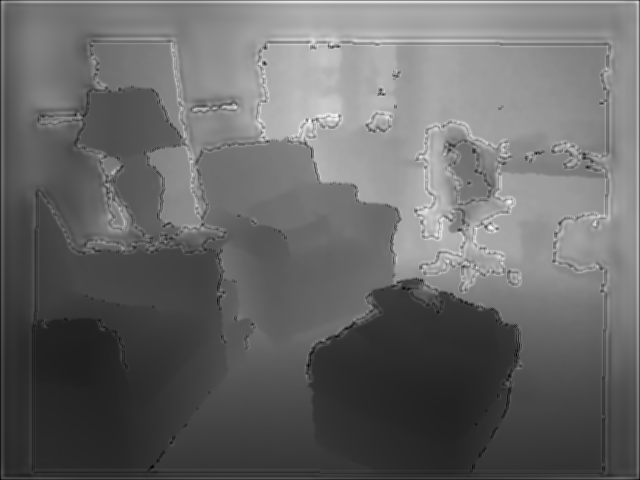

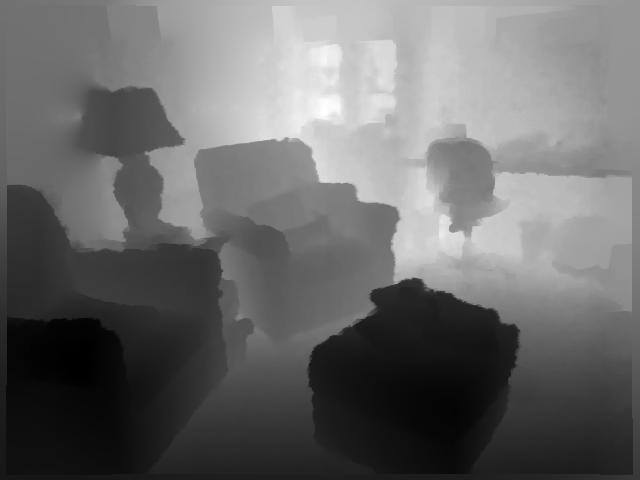

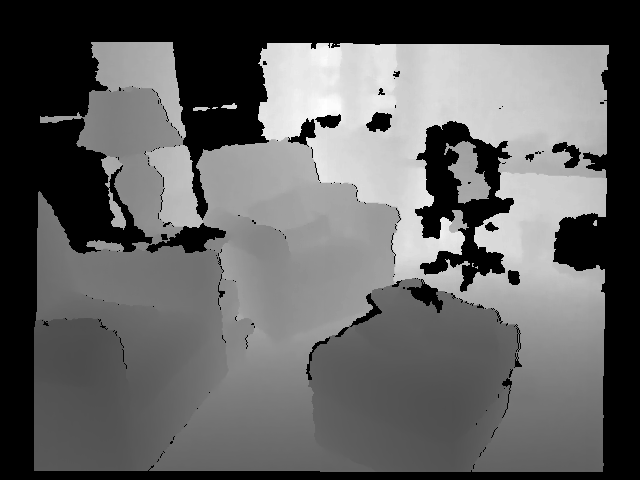

In [ ]:
from google.colab.patches import cv2_imshow
# import matplotlib.pyplot as plt

for i, data in enumerate(test_loader):
  _, inputs, labels = data
  _, inputs, labels = inputs.to(device), labels.to('cpu')

  outputs = model(inputs)
  cpu_batch = outputs.cpu()
  image_batch = cpu_batch.detach().numpy()

  image = image_batch[0]
  image = (image-np.min(image))/(np.max(image)-np.min(image))*255
  print(image.shape)
  cv2_imshow(image[0].astype(np.uint8))
  # plt.imshow(image[0].astype(np.uint8))

  label_batch = labels.detach().numpy()
  label = label_batch[0]
  label = (label-np.min(label))/(np.max(label)-np.min(label))*255
  cv2_imshow(label[0].astype(np.uint8))

  input_cpu_copy = inputs.cpu()
  input_batch = input_cpu_copy.detach().numpy()
  input = input_batch[0]
  input = (input-np.min(input))/(np.max(input)-np.min(input))*255
  cv2_imshow(input[0].astype(np.uint8))
  break




# output_np = output.numpy()
# output_np = (output_np-np.max(output_np))/(np.max(output_np)-np.min(output_np))*255

# cv2_imshow(output_np.astype(np.uint8))